# Gosai et al. Human MPRA Dataset

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import wandb
import tempfile
import pandas as pd
import torch
import sys
sys.path.append("../../")
%matplotlib inline

# wandb.login(host = "https://genentech.wandb.io" )

## 1- Prepare the data

***

In [2]:
# run = wandb.init(entity ='grelu', project="human-mpra-gosai-2023", name = "make_data") # Change depending on your projects
# artifact = run.use_artifact('dataset:v2')
# dir = artifact.download()

In [3]:
# Check Data 
datafile = pd.read_csv("artifacts/DNA-dataset:v0/dataset.csv.gz")
datafile.head()

,Unnamed: 0,chrom,seq,hepg2,k562,sknsh
0,0,chr7,CCTGGTCTTTCTTGCTAAATAAACATATCGTGCATCATCCAGATCT...,0.233601,0.060779,0.047194
1,1,chr1,CATAAAGATGAGGCTTGGCAAAGAACATCTCTCGGTGCCTCCCATT...,0.004565,0.379639,-0.244395
2,2,chr1,CATAAAGCCAATCACTGAGATGACAAGTACTGCCAGGAAAGAAGGC...,0.384537,0.036707,-0.004578
3,3,chr15,CATAAAGGCAGTGTAGACCCAAACAGTGAGCAGTAGCAAGATTTAT...,4.116494,4.508784,3.040183
4,4,chr12,CATAAAGGGCTGAACATGCTGTTGAAAAAATGTAGATATAAAAGTT...,1.423444,1.616602,1.335892


In [4]:
# Select data 
small_data = datafile.loc[
    (datafile['chrom'] =="chr1") | 
    (datafile['chrom'] =="chr2") |
    (datafile['chrom'] =="chr3") |
    (datafile['chrom'] =="chr4") |
    (datafile['chrom'] =="chr5") |
    (datafile['chrom'] =="chr6") |
    (datafile['chrom'] =="chr7") |
    (datafile['chrom'] =="chr8") |
    (datafile['chrom'] =="chr9") |
    (datafile['chrom'] =="chr10") |
    (datafile['chrom'] =="chr11") |
    (datafile['chrom'] =="chr12") |
    (datafile['chrom'] =="chr13") |
    (datafile['chrom'] =="chr14")]

In [5]:
from src.utils.sequence import seqs_to_one_hot

seq_x = [seqs_to_one_hot(seq)[:, 0, :] for seq in small_data['seq']]
small_data_x = np.array(seq_x)
print(small_data_x.shape) # Data Size 

(533979, 200, 4)


## 2- Model training

### Load the dataset

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 1.000e+0

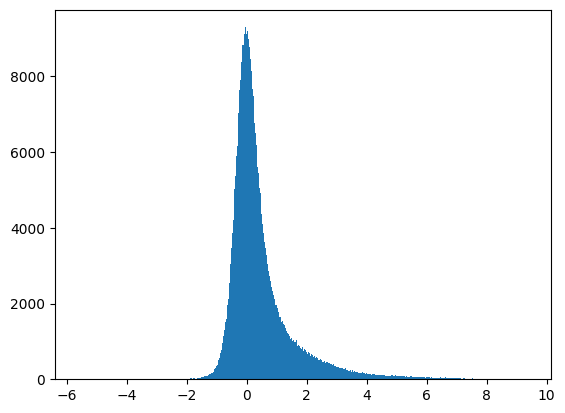

In [6]:
k562_scores = np.array(small_data['k562'])

import matplotlib.pyplot as plt
plt.hist(k562_scores, bins = 'auto')

In [7]:
from grelu.lightning import LightningModel
DEVICE = "cuda:1"

model = LightningModel.load_from_checkpoint("artifacts/DNA-model:v0/reward_model.ckpt")
model.eval()
model.to(DEVICE)

import torch

data_loader = torch.utils.data.DataLoader(small_data_x.astype("float32"), batch_size = 128 , num_workers=0)
relabel_y = []

for batch in data_loader:
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    relabel_y.append( model(batch).detach().cpu() ) 

relabel_y = np.concatenate(relabel_y)

/data/yulai/anaconda3/envs/grelu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/yulai/anaconda3/envs/grelu/lib/python3.9/site-packages/enformer_pytorch/modeling_enformer.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch

In [8]:
print(relabel_y.shape)
# hepg2_relabel_y = relabel_y[:,0].reshape(-1)
k562_relabel_y = relabel_y[:,1].reshape(-1)

print(k562_relabel_y.shape)

(533979, 3, 1)
(533979,)


[-0.31981043 -0.19765935 -0.10255604 -0.01110752  0.08853197  0.21378553
  0.40607165  0.77651888  1.67175174]
(533979,)


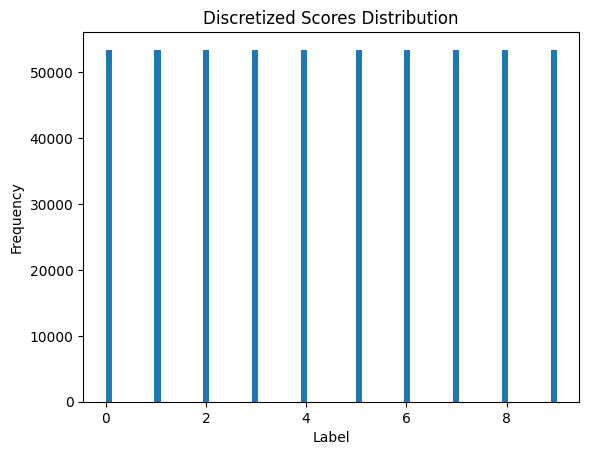

In [9]:
quantiles = np.quantile(k562_relabel_y, np.arange(0.1, 1.0, 0.1))

k562_relabel_y_list = k562_relabel_y.tolist()

print(quantiles)
discretized_indices = []

for idx, score in enumerate(k562_relabel_y_list):
    label = 0
    for q_idx, q_value in enumerate(quantiles):
        if score < q_value:
            break
        label = q_idx + 1
    discretized_indices.append(label)

discretized_indices = np.array(discretized_indices)
print(discretized_indices.shape)

# Plot the histogram of the discretized indices
import matplotlib.pyplot as plt
plt.hist(discretized_indices, bins='auto')
plt.title('Discretized Scores Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

In [10]:
small_data['k562-10class'] = discretized_indices
small_data.head()

/tmp/ipykernel_3622953/1768864567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_data['k562-10class'] = discretized_indices


,Unnamed: 0,chrom,seq,hepg2,k562,sknsh,k562-10class
0,0,chr7,CCTGGTCTTTCTTGCTAAATAAACATATCGTGCATCATCCAGATCT...,0.233601,0.060779,0.047194,5
1,1,chr1,CATAAAGATGAGGCTTGGCAAAGAACATCTCTCGGTGCCTCCCATT...,0.004565,0.379639,-0.244395,4
2,2,chr1,CATAAAGCCAATCACTGAGATGACAAGTACTGCCAGGAAAGAAGGC...,0.384537,0.036707,-0.004578,6
4,4,chr12,CATAAAGGGCTGAACATGCTGTTGAAAAAATGTAGATATAAAAGTT...,1.423444,1.616602,1.335892,8
5,5,chr12,CATAAAGGGCTGAACATGCTGTTGAAAAAATGTAGATATAAAAGTT...,1.444247,1.454357,0.958289,8


### Train/Val/Test split by chromosome

In [11]:
import grelu.data.preprocess

train_chroms = None
val_chroms   = ['chr7']
test_chroms  = ['chr13']

df_train, df_val, df_test = grelu.data.preprocess.split(
    small_data, 
    train_chroms=train_chroms,
    val_chroms=val_chroms,
    test_chroms=test_chroms,
)

df_train = df_train[['seq', 'k562-10class']]
df_val = df_val[['seq', 'k562-10class']]

Selecting training samples
Keeping 471789 intervals


Selecting validation samples
Keeping 42631 intervals


Selecting test samples
Keeping 19559 intervals
Final sizes: train: (471789, 7), val: (42631, 7), test: (19559, 7)


In [12]:
print(df_train.head())

# num_pos = (df_train['k562'] == 1).sum()
# num_neg = (df_train['k562'] == 0).sum()

                                                 seq  k562-10class
1  CATAAAGATGAGGCTTGGCAAAGAACATCTCTCGGTGCCTCCCATT...             4
2  CATAAAGCCAATCACTGAGATGACAAGTACTGCCAGGAAAGAAGGC...             6
4  CATAAAGGGCTGAACATGCTGTTGAAAAAATGTAGATATAAAAGTT...             8
5  CATAAAGGGCTGAACATGCTGTTGAAAAAATGTAGATATAAAAGTT...             8
6  CATAAAGGTAGACCATATGGTCTAGGAAGCAGAGGACAGCTCAGAA...             6


In [13]:
import grelu.data.dataset

train_dataset = grelu.data.dataset.DFSeqDataset(df_train)
val_dataset   = grelu.data.dataset.DFSeqDataset(df_val)

Sequences will be extracted from columns ['seq']
Sequences will be extracted from columns ['seq']


### Start the training!

In [25]:
model_params = {
    'model_type':'EnformerPretrainedModel',
    # 'model_type':'ConvGRUModel',
    # 'model_type': 'BorzoiPretrainedModel',
    'n_tasks': 10,
    'n_transformers': 3,
    # 'n_gru': 3,
    # 'gru_norm': True,
    # 'dropout': 0.05
}

train_params = {
    'task':'multiclass',
    # 'task':'binary',
    'lr':1e-4,
    'logger': 'wandb',
    'batch_size': 128,
    'num_workers': 4,
    'devices': [1],
    'save_dir': 'experiment',
    'optimizer': 'adam',
    'max_epochs': 10,
    'checkpoint': True,
}

In [26]:
import datetime
unique_id = datetime.datetime.now().strftime("%Y.%m.%d_%H.%M.%S")

run_name = "k562_10class/EnformerPretrained/bs=128/lr=1e-4/"
# run_name = "k562_10class/BorzoiPretrainedModel/bs=512/lr=1e-4/"

run_name += f"_{unique_id}"

run = wandb.init(project="RL-conditioning-DNA_oracles-new", name=run_name)

# Build model
import grelu.lightning
from grelu.lightning import LightningModel
    
model = LightningModel(model_params=model_params, train_params=train_params)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
/data/yulai/anaconda3/envs/grelu/lib/python3.9/site-packages/grelu/model/models.py:680: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=

In [27]:
# Train model
trainer = model.train_on_dataset(train_dataset, val_dataset)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/data/yulai/anaconda3/envs/grelu/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


Validation DataLoader 0: 100%|██████████| 334/334 [00:08<00:00, 37.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_accuracy          0.10285027325153351
        val_auroc           0.49425822496414185
       val_avgprec          0.10500746220350266
        val_loss             2.303868055343628
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name         | Type                    | Params | Mode 
-----------------------------------------------------------------
0 | model        | EnformerPretrainedModel | 103 M  | train
1 | loss         | CrossEntropyLoss        | 0      | train
2 | activation   | Softmax                 | 0      | train
3 | val_metrics  | MetricCollection        | 0      | train
4 | test_metrics | MetricCollection        | 0      | train
5 | transform    | Identity                | 0      | train
-----------------------------------------------------------------
103 M     Trainable params
0         Non-trainable params
103 M     Total params
412.617   Total estimated model params size (MB)
299       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 3686/3686 [04:59<00:00, 12.30it/s, v_num=tnq8, train_loss_step=0.775, train_loss_epoch=0.624]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 3686/3686 [05:08<00:00, 11.93it/s, v_num=tnq8, train_loss_step=0.775, train_loss_epoch=0.624]


### Save the model

In [28]:
# artifact = wandb.Artifact('model', type='model')

# artifact.add_file(trainer.checkpoint_callback.best_model_path, 'k562_10class_model.ckpt')
# run.log_artifact(artifact)

In [29]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▄▄▃▂▂▂▁▁
train_loss_step,█▇▇▆▆▅▅▅▄▄▄▄▄▄▅▄▄▃▄▃▂▃▃▃▆▃▃▃▂▂▃▂▂▂▂▁▁▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_accuracy,▁▇█████████
val_auroc,▁██████████
val_avgprec,▁▇█████████
val_loss,█▂▁▁▁▁▁▁▂▂▂
epoch,9
train_loss_epoch,0.62386
train_loss_step,0.5631


***

## 3- Test model

In [30]:
trainer.checkpoint_callback.best_model_path

'experiment/lightning_logs/rv7atnq8/checkpoints/epoch=2-step=11058.ckpt'

In [31]:
df_test = df_test[['seq', 'k562-10class']]
test_dataset = grelu.data.dataset.DFSeqDataset(df_test)

best_model = LightningModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
best_model.eval()
best_model.test_on_dataset(test_dataset, devices=[1], num_workers=0)

Sequences will be extracted from columns ['seq']


wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
/data/yulai/anaconda3/envs/grelu/lib/python3.9/site-packages/grelu/model/models.py:680: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded 

Testing DataLoader 0: 100%|██████████| 77/77 [00:03<00:00, 22.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.5593293309211731
       test_auroc           0.9314808249473572
      test_avgprec          0.5954754948616028
        test_loss           1.0303518772125244
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,test_accuracy,test_auroc,test_avgprec
task_0,0.827530,0.983864,0.877329
task_1,0.517094,0.932722,0.536939
task_2,0.481873,0.908224,0.474820
task_3,0.376366,0.890330,0.411101
task_4,0.439668,0.890557,0.421940
task_5,0.373718,0.886464,0.424398
task_6,0.451323,0.916087,0.514808
task_7,0.514620,0.939466,0.586568
task_8,0.735110,0.970852,0.740774
task_9,0.875991,0.996243,0.966079


### Confusion matrix for each cell type

In [32]:
preds = best_model.predict_on_dataset(test_dataset, devices=[1])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
/data/yulai/anaconda3/envs/grelu/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Predicting DataLoader 0:  55%|█████▍    | 42/77 [00:01<00:01, 24.05it/s]

Predicting DataLoader 0: 100%|██████████| 77/77 [00:03<00:00, 23.77it/s]


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

from typing import Union, List, Optional, Tuple

def plot_confusion_matrix(
    preds: Union[np.ndarray, pd.DataFrame],
    labels: Union[np.ndarray, pd.DataFrame],
    figsize: Tuple[int, int] = (8, 6),
    **kwargs,
):
    """
    Plot a confusion matrix for the classification labels and calculate macro F1 score.

    Args:
        preds: Model predictions (should be probabilities for multiclass)
        labels: True labels
        figsize: Tuple containing (width, height)
        **kwargs: Additional arguments to pass to confusion matrix display

    Returns:
        Confusion matrix plot and macro F1 score
    """
    if isinstance(preds, pd.DataFrame):
        preds = preds.values
    if isinstance(labels, pd.DataFrame):
        labels = labels.values

    # Reshape predictions and labels to remove extra dimensions
    preds = preds.reshape(preds.shape[0], -1)
    labels = labels.reshape(-1)

    # Convert probabilities to class labels for multiclass classification
    if preds.shape[1] > 1:
        y_pred = preds.argmax(axis=1)
    else:
        # For binary classification, assume threshold of 0.5
        y_pred = (preds > 0.5).astype(int).reshape(-1)
    
    y_true = labels.astype(int)

    # Calculate the F1 score (use 'macro' for multiclass)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Macro F1 Score: {f1}")

    # Plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    fig, ax = plt.subplots(figsize=figsize)
    disp.plot(ax=ax, cmap=plt.cm.Blues, **kwargs)
    plt.show()

In [34]:
# # # Example usage with dummy data:
# dummy_preds = np.random.rand(19559, 1, 1)  # Replace with actual predictions
# dummy_labels = np.random.randint(0, 2, size=(19559, 1, 1))  # Replace with actual labels
# plot_confusion_matrix(dummy_preds, dummy_labels)
# print(dummy_preds.shape)
# print(dummy_labels.shape)

### K562

Macro F1 Score: 0.5558567736519857


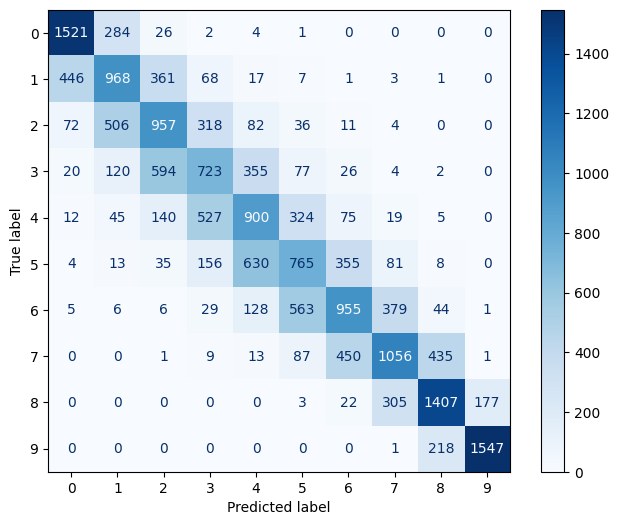

In [35]:
plot_confusion_matrix(preds, test_dataset.labels) # k562